In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.io import ascii

from scipy import stats, interpolate
from scipy.integrate import quad, cumtrapz
from scipy.optimize import curve_fit

import sys
sys.path.append('../../')
import magnification_library as magnification_library
from magnification_library import *

import clmm
from clmm import utils 
import pyccl

from importlib import reload  

In [2]:
#define cosmology

#astropy object
cosmo = FlatLambdaCDM(H0=71, Om0=0.265, Tcmb0=0 , Neff=3.04, m_nu=None, Ob0=0.0448)

#ccl object
cosmo_ccl = pyccl.Cosmology(Omega_c=cosmo.Om0-cosmo.Ob0, Omega_b=cosmo.Ob0,
                      h=cosmo.h, sigma8= 0.80, n_s=0.963)
#clmm object
cosmo_clmm = clmm.Cosmology(be_cosmo=cosmo_ccl)

In [3]:
def shear_pdz(z):
    norm =quad(lambda z: trunc_pdf(z, 1.24, 1.01, 0.51, 0, 3), 0, np.inf)[0]
    return pdf_z(z, 1.24, 1.01, 0.51)/norm

#SHEAR LSST
s_e = 0.26
n_e = 26 / u.arcmin**2 # fiducial number after blending + masking https://arxiv.org/pdf/1305.0793.pdf

alpha = 1.5
pdf_zsource = shear_pdz

In [4]:
z_cl = 0.3
mass_cl = 5*1e14
Delta_SO = 200
zinf = 1e3

In [5]:
radial_unit, rmin, rmax, nbins, method = 'Mpc', 0.1, 7, 10, 'evenlog10width'
binedges = clmm.utils.make_bins(rmin, rmax, nbins=nbins, method=method)

In [6]:
dict_profile =  {'shear': \
                {'model_func': clmm.theory.compute_tangential_shear, \
                'noise_func': lambda Ngal: noise_shear(Ngal , s_e),\
                'model_arg': 1., \
                'source_pdz': pdf_zsource,\
                'source_density': n_e},
                'density contrast': \
                {'model_func':  clmm.theory.compute_magnification, \
                'noise_func': noise_mag,\
                'model_arg': alpha, \
                'source_pdz': pdf_zsource ,\
                'source_density': n_e,\
                'delta_z_cut' : 0.1}}


In [7]:
profile_type = "density contrast"

#concentration = get_halo_concentration(mass_cl, z_cl, cosmo_clmm.be_cosmo, "Diemer15", "matter", Delta_SO )
concentration = 4.
bin_center, bin_edges, N_gal = compute_source_number_per_bin(rmin, rmax, radial_unit, z_cl, dict_profile[profile_type]['source_pdz'],\
                                                            dict_profile[profile_type]['source_density'], nbins, method, cosmo_clmm)

profile_type = "density contrast"
bin_center, bin_edges, noise_m, model_m1 = profile_determination(rmin, rmax, radial_unit , z_cl, mass_cl , profile_type , dict_profile, cosmo_clmm, nbins, method=method, conc=concentration, delta_mdef=200, zinf=zinf)
bin_center, bin_edges, noise_m, model_m2 = profile_determination(rmin, rmax, radial_unit , z_cl, mass_cl , profile_type , dict_profile, cosmo_clmm, nbins, method=method, conc=concentration, delta_mdef=200, zinf=zinf)
bin_center, bin_edges, noise_m, model_m3 = profile_determination(rmin, rmax, radial_unit , z_cl, mass_cl , profile_type , dict_profile, cosmo_clmm, nbins, method=method, conc=concentration, delta_mdef=200, zinf=zinf)

profile_type = "shear"

bin_center, bin_edges, noise_s, model_s = profile_determination(rmin, rmax, radial_unit , z_cl, mass_cl , profile_type , dict_profile, cosmo_clmm, nbins, method=method, conc=concentration, delta_mdef=200, zinf=zinf)


/pbs/throng/lsst/users/mricci/desc/CLMM/clmm/theory/func_layer.py:532: UserWarning: Some source redshifts are lower than the cluster redshift. magnification = 1 for those galaxies.
  warnings.warn(


In [8]:
n_e.to_string()

'26.0 1 / arcmin2'

Text(0.5, 1.0, '$M_{200,m}=5.0x10^{14}M_{\\odot}, z_{cl} = 0.3 $\n$ n_e=26.0 1 / arcmin2,  \\sigma_e=0.26,  \\alpha = 1.5$')

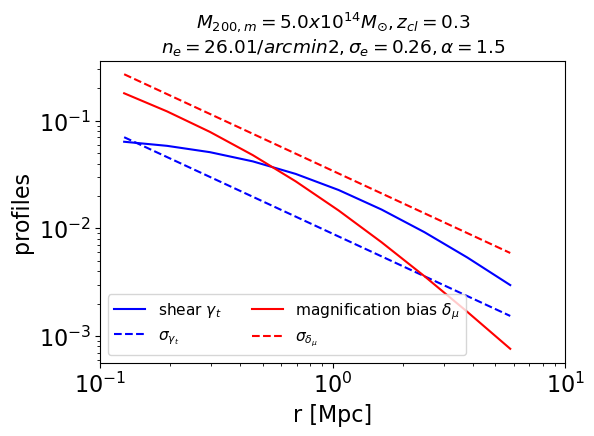

In [9]:
plt.figure(dpi=100)

plt.plot(bin_center, model_s, 'b', label='shear $\gamma_t$')
plt.plot(bin_center, noise_s, 'b',label='$\sigma_{\gamma_t}$', ls='--')

plt.plot(bin_center, abs(model_m1),'r', label='magnification bias $\delta_{\mu}$')
plt.plot(bin_center, noise_m, 'r',label='$\sigma_{\delta_{\mu}}$', ls='--')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('r [Mpc]')
plt.ylabel('profiles')

plt.legend(fontsize='x-small',loc='lower left', ncol=2)
plt.xlim(0.1,10)

plt.title("$M_{200,m}="+str(mass_cl/1e14)+"x10^{14}M_{\odot}, z_{cl} = "+str(z_cl)+" $\n$ n_e="+n_e.to_string()+",  \sigma_e="+str(s_e)+",  \\alpha = "+str(alpha)+"$", fontsize='small')

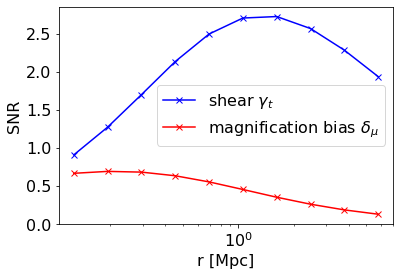

In [15]:

plt.plot(bin_center, model_s/noise_s, 'bx-', label='shear $\gamma_t$')
plt.plot(bin_center, abs(model_m1)/noise_m,'rx-', label='magnification bias $\delta_{\mu}$')

plt.xscale('log')
#plt.yscale('log')

plt.xlabel('r [Mpc]')
plt.ylabel('SNR')

plt.legend()